In [10]:
import sys

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import streamlit as st
import os


# Add the src directory to the Python path
sys.path.append(os.path.abspath('../src'))
# from utils import map_to_mm


#### Let us load the file and see how it looks like

In [11]:
file_name=r'''../data/Model 2025 Baseline  Simulation.xlsx'''
sheet_name=r'''MASTER'''

In [12]:

# Print the current working directory
print("Current working directory:", os.getcwd())

Current working directory: c:\Users\rghosh\OneDrive - Veritiv Corp\AI Lab\Sales Comp Simulation\Notebooks


In [14]:
# Check if the file exists
if os.path.exists(file_name):
     # Read the Excel file into a DataFrame
    df = pd.read_excel(file_name, engine='openpyxl', sheet_name=sheet_name, header=6) # Start reading from row 7
    # Display the first few rows of the DataFrame
    df.head()
else:
    print("File does not exist")


In [15]:
df.head()

,Full Name,ee#,Date of Hire,Years in role as if 12.31,Status,Segment,Position Name,Manager Full Name,Title Description,MODELED TITLE,...,Additional GP$ Growth to break even,2022 Sales,2022 CGP$,2023 Sales,2023 CGP$,2024 Goal,2024 Attainment %,Rate %,Bonus,Final Payment
0,Adam Ketelsen,309490,2024-04-15,0.712329,Y,PK,AKETELS,Todd Fosheim,SR I,SR I,...,0.0,0.00,0.00,0.00,0.00,409694.00,74.95,0.0,3000,0.0
1,Amanda Chapin,309413,2024-03-18,0.789041,Y,PK,ACHAPIN,Todd Fosheim,SR I,SR I,...,0.0,0.00,0.00,0.00,0.00,1426103.68,91.07,0.0,3000,0.0
2,Andrew Smykowski,306444,2019-10-01,5.254795,Y,PK,ASMYKOW,Mike Peters,SR I,SR I,...,0.0,511134.78,137639.45,1010224.71,248696.33,2426510.75,71.01,0.0,3000,0.0
3,Anthony Jordanek,306361,2019-09-03,5.331507,Y,PK,AJORDAN,Stanley Dunton,SR I,SR I,...,0.0,750862.80,203375.64,1315316.55,322868.98,1866431.82,96.67,0.0,3000,0.0
4,Bentley Glenn,309340,2024-01-02,0.997260,Y,PK,BGLENN,Robert Rogers,SR I,SR I,...,0.0,0.00,0.00,0.00,0.00,1001536.48,38.85,0.0,3000,0.0


#### Creating the hash table to retreive the commision and MM Buckets 

In [16]:

# Defining the data
data = {'Base rate': [0.05, 0.07, 0.12], 'Growth Rate': [0.07, 0.11, 0.18], 'Growth Objective': [0.05, 0.08, 0.07]}
# Defining the index
index = ['SR I', 'SR II', 'SR III']
# Casting into DataFrame
df_comp = pd.DataFrame(data, index=index)

In [17]:
# Checking how it looks like
display(df_comp)

,Base rate,Growth Rate,Growth Objective
SR I,0.05,0.07,0.05
SR II,0.07,0.11,0.08
SR III,0.12,0.18,0.07


In [18]:
data={'Multiplier Bands': [0.21, 0.24, 0.29], 'MM': [0.75, 1.0, 1.2]}
df_mm_bands = pd.DataFrame(data)
# Checking how it looks like
display(df_mm_bands)

,Multiplier Bands,MM
0,0.21,0.75
1,0.24,1.00
2,0.29,1.20


#### Plan
1. Find YoY sales growth
2. Apply a noise to the sales growth
3. Find the parameters of the comm margin distribution
4. find comm profit
5. Find commisions for sales
6. Simulate

#### Let us replace the fixed number that got imported to formula

In [19]:
df.columns

Index(['Full Name', 'ee#', 'Date of Hire', 'Years in role as if 12.31',
       'Status', 'Segment', 'Position Name', 'Manager Full Name',
       'Title Description', 'MODELED TITLE', '2024 Sales', '2024 CGP$', 'CGP%',
       '2024 Commission US', '2024 Guarantee True Up',
       'MM freeze impact - included in 2024 comm',
       '2024 Normalized Commissions', 'Eff Rate', 'MM', 'Baseline Commission ',
       'YOY Commission @Baseline', 'Baseline Comm Increase', 'Sales Growth',
       'Growth GP$- asssume flat margin %', 'Growth Commission',
       'Total Commission', 'YOY Comm', 'Addit Rev  to break even',
       'Additional GP$ Growth to break even', '2022 Sales', '2022 CGP$',
       '2023 Sales', '2023 CGP$', '2024 Goal', '2024 Attainment %', 'Rate %',
       'Bonus', 'Final Payment'],
      dtype='object')

In [20]:
df['CGP%']=df['2024 CGP$']/df['2024 Sales']
df['2024 Normalized Commissions']=df['2024 Commission US']-df['2024 Guarantee True Up']-df['MM freeze impact - included in 2024 comm']
df['Eff Rate']=df['2024 Normalized Commissions']/df['2024 CGP$']

In [21]:
df_mm_bands = df_mm_bands.sort_values(by='Multiplier Bands')

# Define a function to map CGP% to MM
def map_to_mm(cgp):
    # Filter rows where 'Multiplier Bands' <= cgp
    valid_rows = df_mm_bands[df_mm_bands['Multiplier Bands'] <= cgp]
    if not valid_rows.empty:
        # Return the MM corresponding to the largest valid 'Multiplier Bands'
        return valid_rows.iloc[-1]['MM']
    return df_mm_bands['MM'].iloc[0]  # Default to the lowest MM if no match

In [22]:
# Apply the function to populate df['MM']
df['MM'] = df['CGP%'].apply(map_to_mm)

# Display the updated DataFrame
display(df['MM'])

0      1.00
1      1.20
2      0.75
3      1.00
4      0.75
       ... 
550    1.00
551    1.00
552    0.75
553    1.00
554    0.75
Name: MM, Length: 555, dtype: float64

In [43]:
# Calculate 'Baseline Commission'
df['Baseline Commission'] = df['Title Description'].apply(
    lambda title: df_comp.loc[title, 'Base rate'] if title in df_comp.index else 0
) * df['2024 CGP$'] * df['MM']

# Display the updated DataFrame
display(df[['Title Description', 'Baseline Commission']])

,Title Description,Baseline Commission
0,SR I,4123.978000
1,SR I,23013.943200
2,SR I,13861.201125
3,SR I,22270.294500
4,SR I,3335.366250
...,...,...
550,SR III,284869.902000
551,SR III,157319.802000
552,SR III,185435.631900
553,SR III,124862.761200


#### Updating the formula for the remaining columns

In [41]:
df['YOY Commission @Baseline']=df['Baseline Commission']-df['2024 Normalized Commissions']
df['Baseline Comm Increase']=df['YOY Commission @Baseline'].apply(lambda x: 1 if x>0 else 0)
df['Sales Growth']=df['Title Description'].apply(
    lambda title: df_comp.loc[title, 'Growth Objective'] if title in df_comp.index else 0
) * df['2024 Sales']
df['Growth GP$- asssume flat margin %']=df['CGP%']*df['Sales Growth']
df[' Growth Commission']=df['Title Description'].apply(
    lambda title: df_comp.loc[title, 'Growth Rate'] if title in df_comp.index else 0
) * df['Growth GP$- asssume flat margin %'] * df['MM']
df['Total Commission']=df['2024 Commission US']+df['Growth Commission']
df['YOY Comm']= df['Total Commission']-df['2024 Commission US']


In [42]:
display(df['YOY Comm'])

0        288.678460
1       1610.976024
2        970.284079
3       1558.920615
4        233.475637
           ...     
550    29911.339710
551    16518.579210
552    19470.741349
553    13110.589926
554    40225.756883
Name: YOY Comm, Length: 555, dtype: float64

In [ ]:
class Simulation:
    def __init__(self, df, df_comp, df_mm_bands):
        self.df = df
        self.df_comp = df_comp
        self.df_mm_bands = df_mm_bands.sort_values(by='Multiplier Bands')
        self.cgp_dist = self.df['CGP%'].dropna().values  # Store CGP% distribution

    # def calculate_columns(self, year='2024'):
    #     """Calculate all columns for a given year."""
    #     sales_col = f'{year} Sales' if f'{year} Sales' in self.df.columns else '2024 Sales'
    #     cgp_col = f'{year} CGP$' if f'{year} CGP$' in self.df.columns else '2024 CGP$'
    #     comm_col = f'{year} Commission US' if f'{year} Commission US' in self.df.columns else '2024 Commission US'
    #     guarantee_col = f'{year} Guarantee True Up' if f'{year} Guarantee True Up' in self.df.columns else '2024 Guarantee True Up'
    #     mm_freeze_col = 'MM freeze impact - included in 2024 comm'  # Assuming this doesn't change

    #     self.df[f'{year} CGP%'] = self.df[cgp_col] / self.df[sales_col]

    #     # Map CGP% to MM
    #     def map_to_mm(cgp):
    #         valid_rows = self.df_mm_bands[self.df_mm_bands['Multiplier Bands'] <= cgp]
    #         if not valid_rows.empty:
    #             return valid_rows.iloc[-1]['MM']
    #         return self.df_mm_bands['MM'].iloc[0]
    #     self.df[f'{year} MM'] = self.df[f'{year} CGP%'].apply(map_to_mm)

    #     # Baseline Commission
    #     self.df[f'{year} Baseline Commission'] = self.df['Title Description'].apply(
    #         lambda title: self.df_comp.loc[title, 'Base rate'] if title in self.df_comp.index else 0
    #     ) * self.df[cgp_col] * self.df[f'{year} MM']

    #     # Normalized Commissions
    #     self.df[f'{year} Normalized Commissions'] = (
    #         self.df[comm_col] - self.df[guarantee_col] - self.df[mm_freeze_col]
    #     )
    #     self.df[f'{year} Eff Rate'] = self.df[f'{year} Normalized Commissions'] / self.df[cgp_col]

    def simulate_total_commission(
        self, 
        num_simulations=100, 
        years=range(2025, 2031),  # 2025-2030 inclusive
        growth_std=0.005,         # 0.5% std dev for growth objective
        cgp_sample_std=None       # Not used, but can be added for more noise
    ):
        base_sales = self.df['2024 Sales'].copy()
        base_commission = self.df['2024 Commission US'].copy()
        simulation_results = []

        for sim in range(num_simulations):
            sim_df = self.df.copy()
            prev_sales = base_sales.copy()
            prev_commission = base_commission.copy()

            for year in years:
                # 1. Sample Growth Objective for each rep
                growth_objective = sim_df['Title Description'].apply(
                    lambda title: self.df_comp.loc[title, 'Growth Objective'] if title in self.df_comp.index else 0
                ).values
                growth_objective_noisy = np.random.normal(growth_objective, growth_std)

                # 2. Calculate Sales Growth for this year
                sales_growth = prev_sales * growth_objective_noisy
                sim_df[f'{year} Sales Growth'] = sales_growth

                # 3. Calculate current year Sales
                curr_sales = prev_sales + sales_growth
                sim_df[f'{year} Sales'] = curr_sales

                # 4. Sample CGP% for each rep
                sampled_cgp_pct = np.random.choice(self.cgp_dist, size=len(sim_df), replace=True)
                sim_df[f'{year} CGP%'] = sampled_cgp_pct

                # 5. Calculate Growth GP$ (assume flat margin %)
                growth_gp = sampled_cgp_pct * sales_growth
                sim_df[f'{year} Growth GP$- asssume flat margin %'] = growth_gp

                # 6. Calculate Growth Commission
                growth_rate = sim_df['Title Description'].apply(
                    lambda title: self.df_comp.loc[title, 'Growth Rate'] if title in self.df_comp.index else 0
                ).values
                mm = sim_df['MM'].values if 'MM' in sim_df.columns else 1.0  # Use 1.0 if MM not present
                growth_commission = growth_rate * growth_gp * mm
                sim_df[f'{year} Growth Commission'] = growth_commission

                # 7. Calculate Total Commission
                total_commission = prev_commission + growth_commission
                sim_df[f'{year} Total Commission'] = total_commission

                # Prepare for next year
                prev_sales = curr_sales
                prev_commission = total_commission

            sim_df['Simulation'] = sim
            simulation_results.append(sim_df)

        all_simulations = pd.concat(simulation_results, ignore_index=True)
        return all_simulations

    def plot_total_commission(self, results, rep_name, years=range(2025, 2032)):
        """Plot total commission for a selected rep across years."""
        rep_data = results[results['Full Name'] == rep_name]
        plt.figure(figsize=(10, 6))
        for year in years:
            plt.hist(rep_data[f'{year} Total Commission'], bins=30, alpha=0.5, label=str(year))
        plt.title(f'Total Commission Distribution for {rep_name}')
        plt.xlabel('Total Commission')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

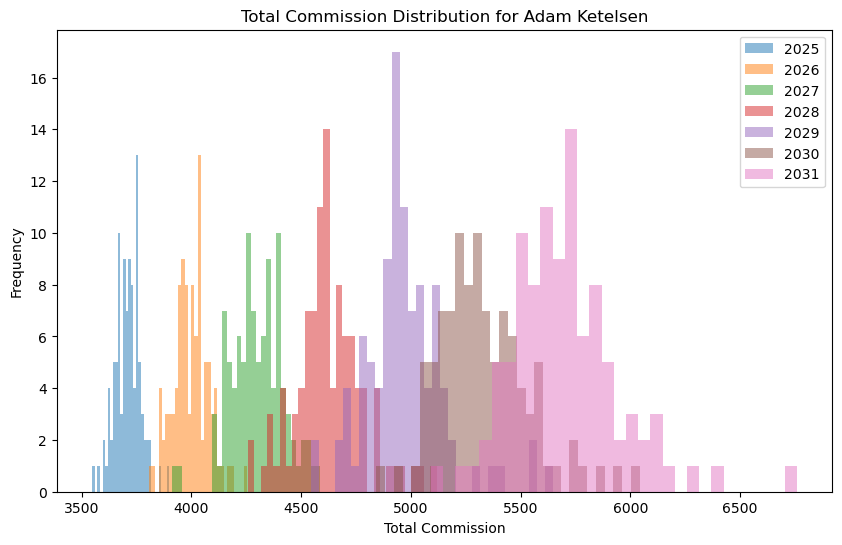

In [47]:
# User selects rep
rep_name = st.selectbox('Select Sales Rep', df['Full Name'].unique())

# User edits df_comp (example for 'Base rate')
for title in df_comp.index:
    df_comp.loc[title, 'Base rate'] = st.number_input(f'Base rate for {title}', value=float(df_comp.loc[title, 'Base rate']))

# Run simulation
simulation = Simulation(df, df_comp, df_mm_bands)
results = simulation.simulate_total_commission(num_simulations=100)

# Plot for selected rep
simulation.plot_total_commission(results, rep_name)